<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/NataPereU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
!pip install bambi
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.1 MB/s eta 0:00:00


my goal is to predict how much HR is affected in result to different factors, more specifically, batting average, pitching average, and slugging. Likely accounting for factors like Age and team

In [20]:
#load the data into a pandas dataframe
url_baseball = 'https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv'
baseball = pd.read_csv(url_baseball)

In [21]:
baseball

,k,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos
0,1.0,Jarren Duran*,27.0,BOS,AL,8.7,160.0,735.0,671.0,111.0,...,129.0,0.373,134.0,330.0,6.0,6.0,1.0,3.0,1.0,OF
1,2.0,Shohei Ohtani*,29.0,LAD,NL,9.2,159.0,731.0,636.0,134.0,...,190.0,0.449,190.0,411.0,7.0,6.0,0.0,5.0,10.0,DH
2,3.0,Gunnar Henderson*,23.0,BAL,AL,9.1,159.0,719.0,630.0,118.0,...,159.0,0.385,157.0,333.0,2.0,7.0,0.0,4.0,1.0,SS
3,4.0,Marcus Semien,33.0,TEX,AL,4.1,159.0,718.0,650.0,101.0,...,100.0,0.310,100.0,254.0,9.0,3.0,0.0,1.0,2.0,2B
4,5.0,Juan Soto*,25.0,NYY,AL,7.9,157.0,713.0,576.0,128.0,...,178.0,0.424,179.0,328.0,10.0,4.0,0.0,4.0,2.0,OF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,738.0,Josh Winckowski,26.0,BOS,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
772,739.0,Kirby Yates*,37.0,TEX,AL,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
773,740.0,Alex Young*,30.0,CIN,NL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
774,741.0,Guillo Zuñiga,25.0,LAA,AL,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [34]:
#load the data into a pandas dataframe
url_baseball = 'https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv'
df_baseball = pd.read_csv(url_baseball) # Change the variable name to df_baseball to avoid conflict with a function named baseball.

# Perform data filtering and selection
df_baseball = df_baseball.query('PA>200')
df_baseball = df_baseball[['Player', 'WAR', 'BA', 'SLG', 'OBP', 'HR', 'Pos']]
df_baseball

,Player,WAR,BA,SLG,OBP,HR,Pos
0,Jarren Duran*,8.7,0.285,0.492,0.342,21.0,OF
1,Shohei Ohtani*,9.2,0.310,0.646,0.390,54.0,DH
2,Gunnar Henderson*,9.1,0.281,0.529,0.364,37.0,SS
3,Marcus Semien,4.1,0.237,0.391,0.308,23.0,2B
4,Juan Soto*,7.9,0.288,0.569,0.419,41.0,OF
...,...,...,...,...,...,...,...
360,Trent Grisham*,0.4,0.190,0.385,0.290,9.0,OF
361,Kyle Stowers*,-0.5,0.208,0.333,0.268,3.0,UTIL
362,Jackson Holliday*,0.1,0.189,0.311,0.255,5.0,2B
363,Jorge Mateo,0.9,0.229,0.401,0.267,5.0,2B


<Axes: xlabel='HR', ylabel='BA'>

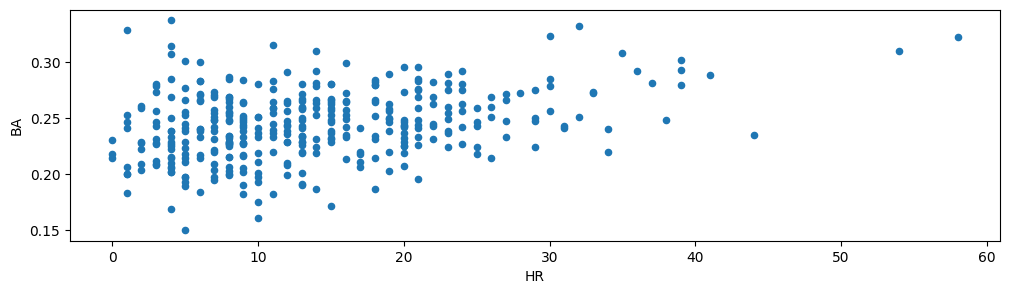

In [5]:
baseball.plot(x="HR", y="BA", figsize=(12, 3), kind="scatter")

im seeing a bit of a correlation, a higher HR means a higher BA. However, it still seems possible to have a high batting average and low HR. I think this data could be defined as relatively linear, however i think it could be better, im going to compare SLG to HR to see if that gives me a better line to follow.

<Axes: xlabel='HR', ylabel='SLG'>

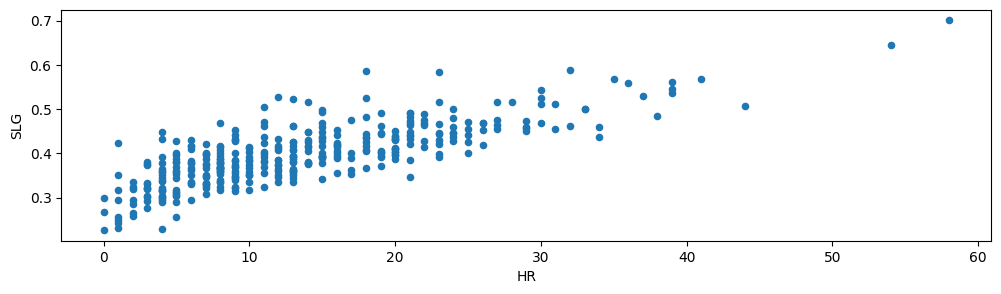

In [6]:
baseball.plot(x="HR", y="SLG", figsize=(12, 3), kind="scatter")

there definetly is still grouping, but i think im going to use Hr in comparison tp SLG for this next linear model.

In [39]:
#define the model
model1 = bmb.Model("SLG ~ HR", data=df_baseball) # Change baseball to df_baseball
#fit the model
idata_model1 = model1.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


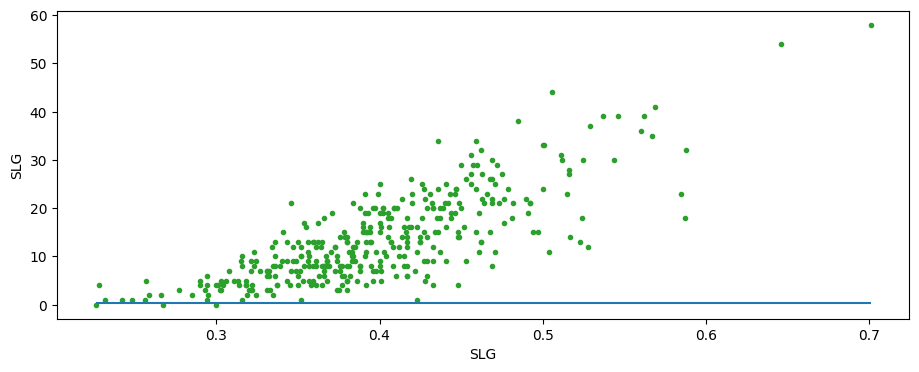

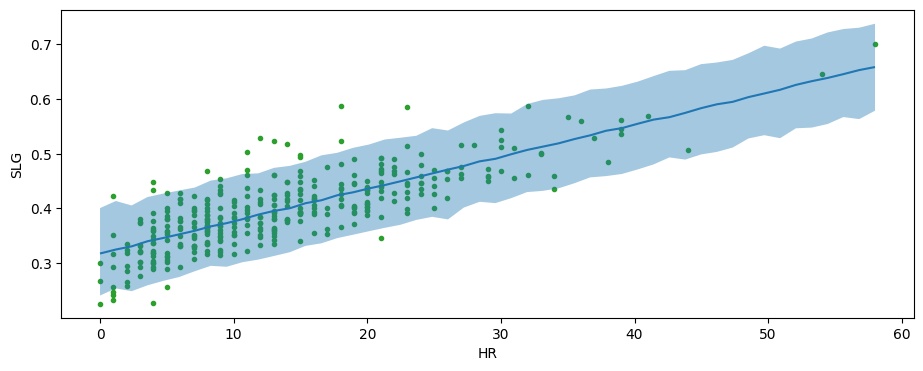

In [41]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model1, idata_model1, ["SLG"], fig_kwargs={"figsize":(11, 4)})
plt.plot(df_baseball.SLG, df_baseball.HR, "C2.", zorder=-3) # Change baseball to df_baseball

bmb.interpret.plot_predictions(model1, idata_model1, ["HR"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(df_baseball.HR, df_baseball.SLG, "C2.", zorder=-3) # Change baseball to df_baseball

In [48]:
#define the model
model2 = bmb.Model("SLG ~ HR + BA", data=df_baseball) # Change baseball to df_baseball
#fit the model
idata_model2 = model2.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


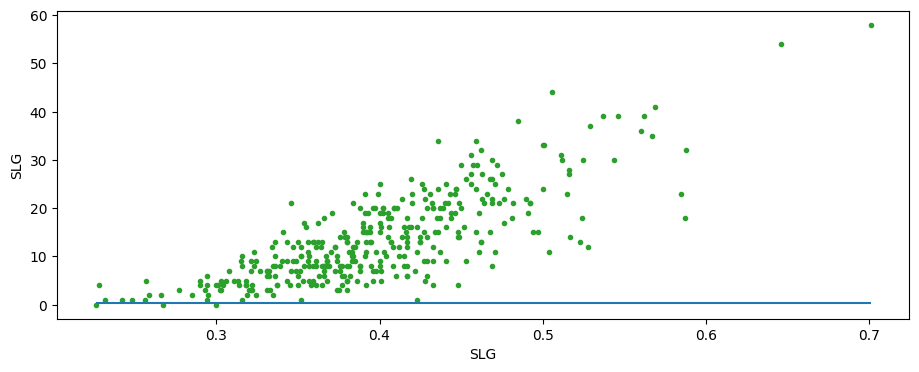

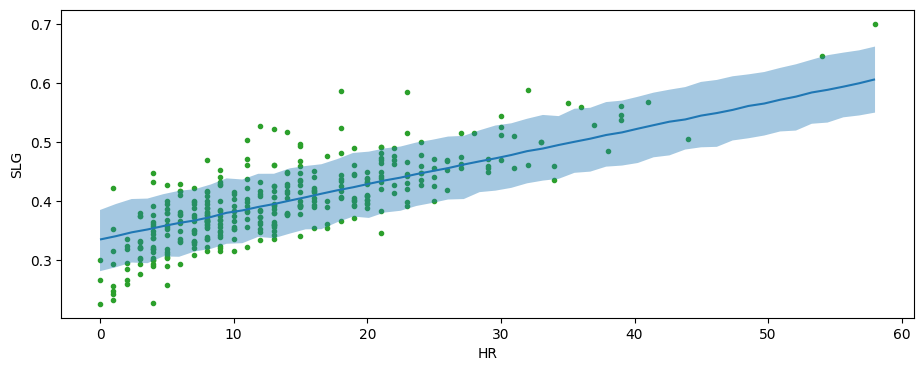

In [51]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model2, idata_model2, ["SLG"], fig_kwargs={"figsize":(11, 4)})
plt.plot(df_baseball.SLG, df_baseball.HR, "C2.", zorder=-3) # Change baseball to df_baseball

bmb.interpret.plot_predictions(model2, idata_model2, ["HR"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(df_baseball.HR, df_baseball.SLG, "C2.", zorder=-3) # Change baseball to df_baseball

In [50]:
#define the model
model3 = bmb.Model("SLG ~ HR + BA + WAR + OBP", data=df_baseball) # Change baseball to df_baseball
#fit the model
idata_model3 = model3.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


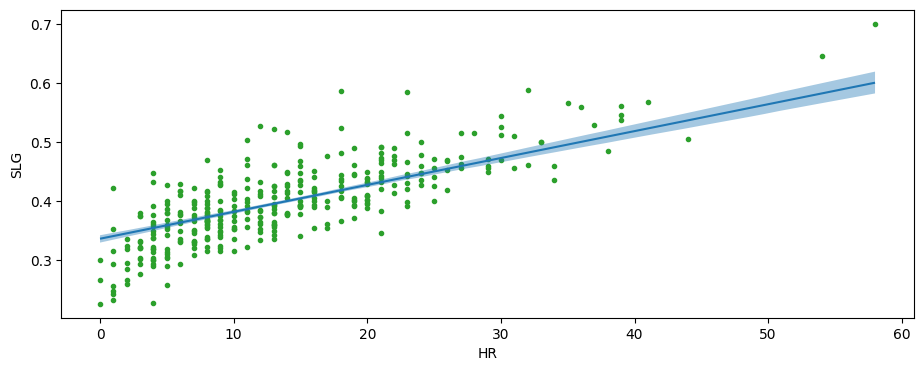

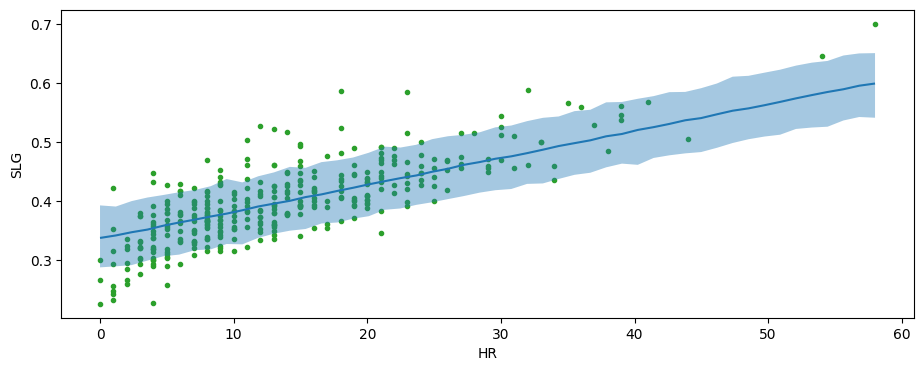

In [53]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model3, idata_model3, ["HR"], fig_kwargs={"figsize":(11, 4)})
plt.plot(df_baseball.HR, df_baseball.SLG, "C2.", zorder=-3) # Change baseball to df_baseball

bmb.interpret.plot_predictions(model3, idata_model3, ["HR"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(df_baseball.HR, df_baseball.SLG, "C2.", zorder=-3) # Change baseball to df_baseball

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

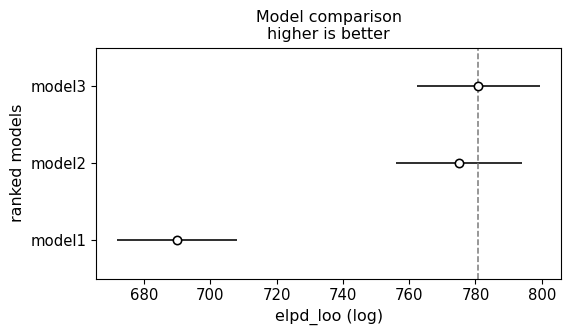

In [54]:
loo_1 = az.loo(idata_model1)
loo_2 = az.loo(idata_model2)
loo_3 = az.loo(idata_model3)

cmp_df = az.compare({"model1":idata_model1, "model2":idata_model2, "model3":idata_model3})
cmp_df
az.plot_compare(cmp_df)

These models diverge greatly in their Elpd_loo, model 3 actually does the better job out of the three to accurately. To me this is kind of crazy because this is the model wiht the most factors -- i was nervous/expecting model 3 to be a result of overfitting, however this has proved to be the opposite. model 1, the one with the least factors is actually less effective than model 2 and 3, both of which have at least 1 more factor

My best model is the one that reflects SLG, HR , BA, WAR, OBP